In [30]:
import numba as nb
import numpy as np
import matplotlib.pyplot as plt

from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid

In [31]:
import numba as nb
import numpy as np

from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid
import pde as pde


class BrusselatorPDE(PDEBase):
    """Brusselator with diffusive mobility"""

    def __init__(self, a=1, b=3, diffusivity=[1, 2], bc="auto_periodic_neumann"):
        super().__init__()
        self.a = a
        self.b = b
        self.diffusivity = diffusivity  # spatial mobility
        self.bc = bc  # boundary condition

    def get_initial_state(self, grid):
        """prepare a useful initial state"""
        # u = ScalarField(grid, 0, label="Field $u$")
        # v = ScalarField.random_uniform(grid, label="Field $v$")
        u = ScalarField(grid, self.a, label="Field $u$")
        v = self.b / self.a + 0.1 * ScalarField.random_normal(grid, label="Field $v$")
        return FieldCollection([u, v])

    def evolution_rate(self, state, t=0):
        """pure python implementation of the PDE"""
        u, v = state
        rhs = state.copy()
        d0, d1 = self.diffusivity
        # rhs[0] = d0 * u.laplace(self.bc) + u**2*v - (self.a+self.b)*u
        # rhs[1] = d1 * v.laplace(self.bc) -u**2*v + self.a*(1-v)
        rhs[0] = d0 * u.laplace(self.bc) + self.a - (self.b + 1) * u + u**2 * v
        rhs[1] = d1 * v.laplace(self.bc) + self.b * u - u**2 * v
        return rhs

    def _make_pde_rhs_numba(self, state):
        """nunmba-compiled implementation of the PDE"""
        d0, d1 = self.diffusivity
        a, b = self.a, self.b
        laplace = state.grid.make_operator("laplace", bc=self.bc)

        @nb.njit
        def pde_rhs(state_data, t):
            u = state_data[0]
            v = state_data[1]

            rate = np.empty_like(state_data)
            # rate[0] = d0 * laplace(u) + u**2*v - (a+b)*u
            # rate[1] = d1 * laplace(v) - u**2*v + a*(1-v)
            rate[0] = d0 * laplace(u) + a - (1 + b) * u + v * u**2
            rate[1] = d1 * laplace(v) + b * u - v * u**2

            return rate

        return pde_rhs


# initialize state
grid = UnitGrid([64, 64])
eq = BrusselatorPDE(diffusivity=[1, 0.1])
state = eq.get_initial_state(grid)

# simulate the pde
plotter = PlotTracker(interrupts=1, plot_args={"kind": "merged", "vmin": 0, "vmax": 5})
storage = pde.MemoryStorage()
sol = eq.solve(state, t_range=20, dt=1e-3, tracker=["progress",storage.tracker(1)])

  0%|          | 0/20.0 [00:00<?, ?it/s]

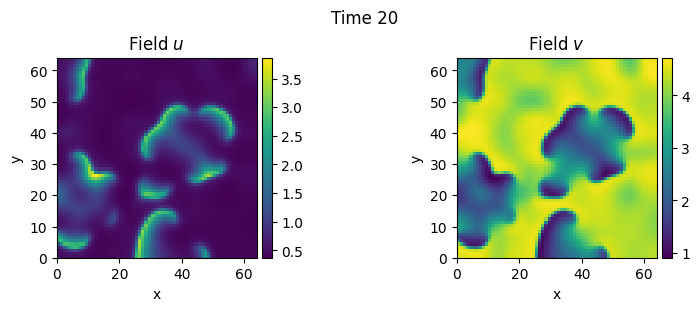

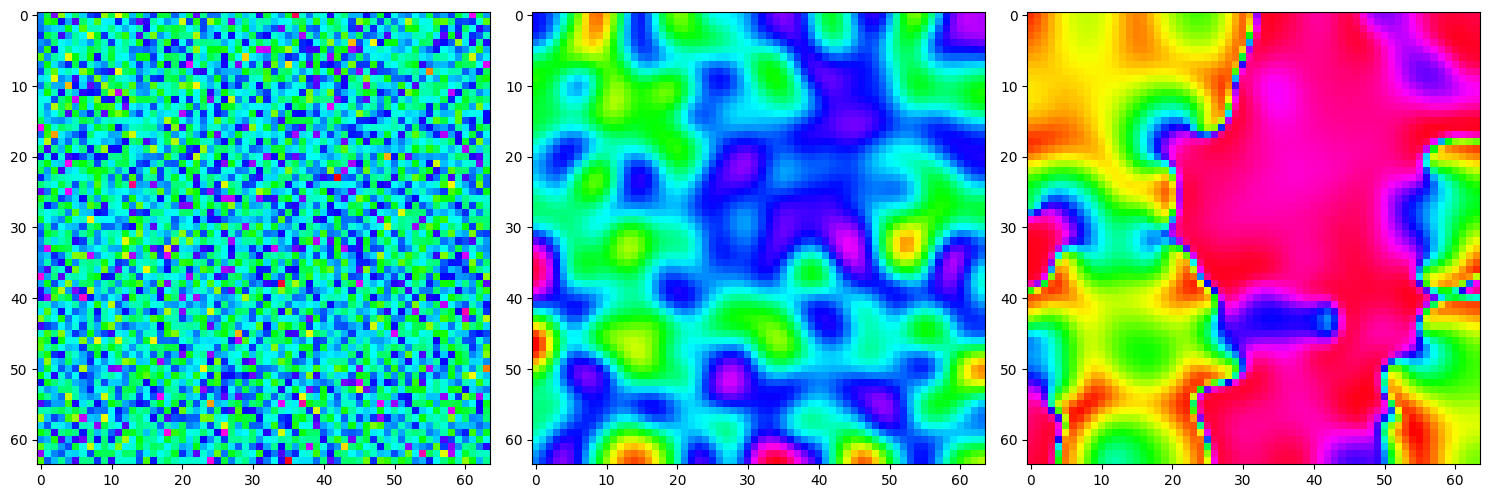

In [32]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im0 = axes[0].imshow(state.data[1,:,:], cmap='hsv')
im1 = axes[1].imshow(storage.data[5][1,:,:], cmap='hsv')
im2 =axes[2].imshow(storage.data[-1][1,:,:], cmap='hsv')


plt.tight_layout()
plt.show()

In [33]:
pde.movie(storage,"test.mp4",movie_args={"framerate":15})

  0%|          | 0/21 [00:00<?, ?it/s]

## Playground

In [98]:
import numba as nb
import numpy as np

from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid
import pde as pde


class BrusselatorPDE(PDEBase):
    """Brusselator with diffusive mobility"""

    def __init__(self, grid, L=64, D=1, a=1, b=3, bc="auto_periodic_neumann"):
        super().__init__()
        self.a = a
        self.b = b
        self.L = L
        self.D = D
        self.grid = grid
        self.bc = bc  # boundary condition

    def u_0(self):
        """prepare a useful initial state"""
        # u = ScalarField(grid, 0, label="Field $u$")
        # v = ScalarField.random_uniform(grid, label="Field $v$")
        u = ScalarField.from_expression(self.grid,"exp(-((x-64/10)**2+(y-64/2)**2)/(64/5)**2)")
        return u

    def F(self):
        consts = {"L":self.L}
        expr = ["-(y-L/2)/((x-L/2)**2+(y-L/2)**2+0.01)**(1/2)","(x-L/2)/((x-L/2)**2+(y-L/2)**2+0.01)**(1/2)"]
        F = pde.VectorField.from_expression(self.grid,expr,consts=consts)
        return F

    def evolution_rate(self, u, F, t=0):
        """pure python implementation of the PDE"""
        div = self.grid.make_operator("divergence",bc=self.bc)
        u = self.D*u.laplace(self.bc) + div(u*F)
        return rhs

    # def _make_pde_rhs_numba(self, state):
    #     """nunmba-compiled implementation of the PDE"""
    #     laplace = self.grid.make_operator("laplace", bc=self.bc)
    #     div = self.grid.make_operator("divergence",bc=self.bc)
    #     D = self.D

    #     @nb.njit
    #     def pde_rhs(u, t):
    #         rate = np.empty_like(u)
    #         # rate[0] = d0 * laplace(u) + u**2*v - (a+b)*u
    #         # rate[1] = d1 * laplace(v) - u**2*v + a*(1-v)
    #         rate = D*u.laplace(self.bc) + div(u*F)

    #         return rate

    #     return pde_rhs


# initialize state
L = 64
grid = UnitGrid([64, 64])
eq = BrusselatorPDE(grid,L)
u = eq.u_0()
F = eq.F()

# simulate the pde
plotter = PlotTracker(interrupts=1, plot_args={"kind": "merged", "vmin": 0, "vmax": 5})
storage = pde.MemoryStorage()
sol = eq.solve(u, t_range=20, dt=1e-3, tracker=["progress",storage.tracker(1)])

  0%|          | 0/20.0 [00:00<?, ?it/s]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /home/alifeleparanj/Programs/venvs/Computation/lib/python3.10/site-packages/pde/grids/base.py (1476)

File "../../../../../Programs/venvs/Computation/lib/python3.10/site-packages/pde/grids/base.py", line 1476:
                    def apply_op_impl(
                        <source elided>

            @jit
            ^ 

This error may have been caused by the following argument(s):
- argument 0: Cannot determine Numba type of <class 'pde.fields.scalar.ScalarField'>


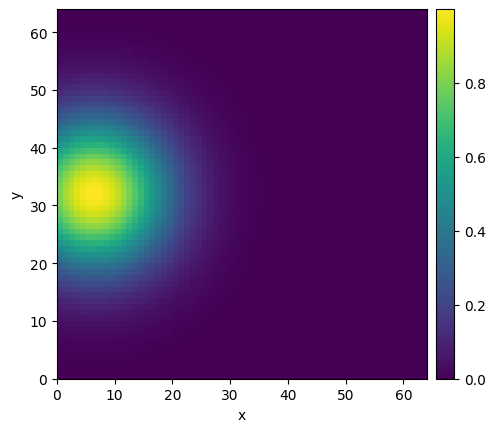

In [85]:
state.plot()

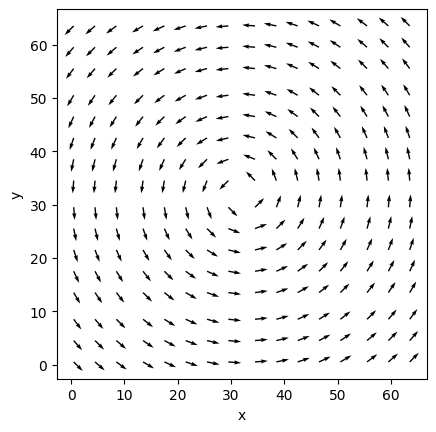

In [80]:
F.plot()